<div class="header">
  <img src="img/kg_logo_white_side.png" alt="logo" style="width: 300px;"/>
  <h1>Transaction Monitoring with Graph Neural Networks (End-to-end pipeline)</h1>
</div>

The Elliptic Data Set maps Bitcoin transactions to real entities belonging to licit categories (exchanges, wallet providers, miners, licit services, etc.) versus illicit ones (scams, malware, terrorist organizations, ransomware, Ponzi schemes, etc.). The task on the dataset is to classify the illicit and licit nodes in the graph.
We will use Graph Neural Networks (GraphSAGE) to perform the node classification task. This demo shows the end-to-end pipeline that can be done directly on the Katana Graph platform. 

-------

### Setup

In [1]:
import os                                                                        
import time                                                                      
import json
import uuid
import pandas as pd
import numpy
import argparse
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
#import xgboost
from timeit import default_timer as timer
import warnings
warnings.filterwarnings('ignore')

from katana import remote
from katana.remote import import_data
from katana.remote.import_data import Operation

import dask.dataframe as dd
from dask.distributed import Client
#import dask_xgboost as dxgb
import dask.array as da

### Dask Dataframe Import

In [2]:
tx_classes = "gs://katana-demo-datasets/fsi/solution_raw_data/elliptic/elliptic_txs_classes.csv"
tx_edges = "gs://katana-demo-datasets/fsi/solution_raw_data/elliptic/elliptic_txs_edgelist.csv"
tx_features = "gs://katana-demo-datasets/fsi/solution_raw_data/elliptic/elliptic_txs_features.csv"

In [3]:
feat_col_names = ["account_id", "timestamp"]
local_feats_name = [f"local_feat_{i}" for i in range(2,95)]
agg_feats_name = [f"agg_feat_{i}" for i in range(95,167)]
feat_col_names.extend(local_feats_name)
feat_col_names.extend(agg_feats_name)

In [4]:
feat_types = {
    "class": "string",
    "timestamp": "string", 
    "target": "float",
    "node_type": "string"
}
local_cols = {}
for i in range(2,95):
    local_cols[f"local_feat_{i}"] = "float"
agg_cols = {}
for i in range(95,167):
    agg_cols[f"agg_feat_{i}"] = "float"
feat_types.update(local_cols)
feat_types.update(agg_cols)

In [5]:
%%time
classes = dd.read_csv(tx_classes)
edges = dd.read_csv(tx_edges)
features = dd.read_csv(tx_features, header=None, names=feat_col_names)

CPU times: user 309 ms, sys: 83.9 ms, total: 393 ms
Wall time: 1.28 s


### Exploring the datasets

<AxesSubplot: >

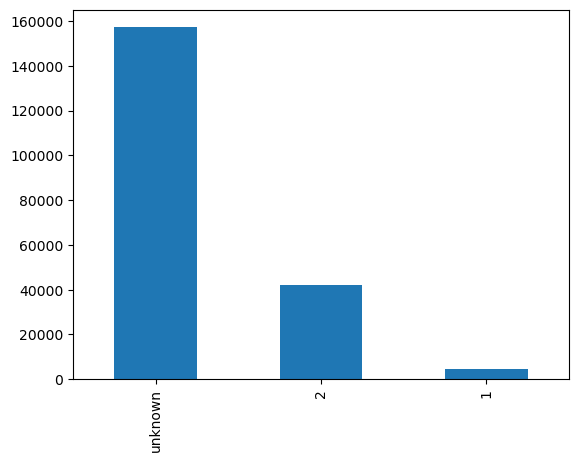

In [6]:
classes['class'].value_counts().compute().plot(kind='bar')

In [7]:
classes['target'] = classes['class'].map({'unknown': 0.0, '1': 1.0, '2': 0.0})
classes['node_type'] = classes['class'].map({'unknown': 'Unclassified_Acct', '1': 'Classified_Acct', '2': 'Classified_Acct'})

In [8]:
classes = classes.rename(columns={"txId": "account_id"})  
classes.head()

,account_id,class,target,node_type
0,230425980,unknown,0.0,Unclassified_Acct
1,5530458,unknown,0.0,Unclassified_Acct
2,232022460,unknown,0.0,Unclassified_Acct
3,232438397,2,0.0,Classified_Acct
4,230460314,unknown,0.0,Unclassified_Acct


In [9]:
edges = edges.rename(columns={"txId1": "account_id_src", "txId2": "account_id_dst"})  
edges.head()

,account_id_src,account_id_dst
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [10]:
features.head()

,account_id,timestamp,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,local_feat_8,local_feat_9,...,agg_feat_157,agg_feat_158,agg_feat_159,agg_feat_160,agg_feat_161,agg_feat_162,agg_feat_163,agg_feat_164,agg_feat_165,agg_feat_166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [11]:
nodes = features.merge(classes)
nodes.head()

,account_id,timestamp,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,local_feat_8,local_feat_9,...,agg_feat_160,agg_feat_161,agg_feat_162,agg_feat_163,agg_feat_164,agg_feat_165,agg_feat_166,class,target,node_type
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,unknown,0.0,Unclassified_Acct
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,unknown,0.0,Unclassified_Acct
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,unknown,0.0,Unclassified_Acct
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,2,0.0,Classified_Acct
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,unknown,0.0,Unclassified_Acct


## Graph Preparation and GNN Training Pipeline

### Graph Creation
There is a 4 node cluster running on GCP, which is why we select 4 partitions. As the data scales, we can increase the number of machines in the cluster and the number of partitions in our graph

In [12]:
graph = remote.Client(disable_version_check=False).create_graph(
    num_partitions=4
)
print("graph id:", graph.graph_id)

graph id: BuBJfjxtDWV1zWADZpCup91muexKYRMysqdSRADEBamn


In [13]:
%%time
reverse_edges=True
with import_data.DataFrameImporter(graph) as df_importer:   
    
    df_importer.nodes_dataframe(nodes,
                            id_column="account_id",
                            id_space="account", 
                            property_columns=feat_types,
                            label_column="node_type")
    
    df_importer.edges_dataframe(edges,
                            source_id_space="account",
                            destination_id_space="account",
                            source_column="account_id_src",
                            destination_column="account_id_dst",
                            type="transaction")
    if reverse_edges:
        df_importer.edges_dataframe(edges,
                        source_id_space="account",
                        destination_id_space="account",
                        source_column="account_id_dst",
                        destination_column="account_id_src",
                        type="rev_transaction")
    df_importer.insert()

          0/? [?op/s]

          0/? [?op/s]

CPU times: user 3.62 s, sys: 142 ms, total: 3.76 s
Wall time: 29.3 s


In [14]:
print(f"Number of nodes: {graph.num_nodes():,}")
print(f"Number of edges: {graph.num_edges():,}")

          0/? [?op/s]

Number of nodes: 203,769


          0/? [?op/s]

Number of edges: 468,710


### Visualization

In [15]:
%%time
graph.query("""
MATCH (tx1)-[:transaction]->(tx2)
RETURN tx1, tx2
LIMIT 500
""", contextualize=True).visualize()

          0/? [?op/s]

          0/? [?op/s]

CPU times: user 3.43 s, sys: 379 ms, total: 3.8 s
Wall time: 34.5 s


GraphVizWidget(edges=[{'from': 12760, 'to': 12607, 'label': 'transaction', 'type': 'transaction', 'properties'…

### Graph Analytics

#### Page Rank

In [16]:
from katana.remote.analytics import pagerank
property_name = "pr"
pagerank(graph, property_name)
graph.query("MATCH (acct) RETURN acct.id AS account, acct.pr AS rank ORDER BY rank DESC LIMIT 10")


          0/? [?op/s]

          0/? [?op/s]

,account,rank
0,None,36.323883
1,None,25.046713
2,None,21.945116
3,None,21.901606
4,None,20.820234
5,None,19.476994
6,None,18.411884
7,None,18.105764
8,None,17.434237
9,None,16.871368


#### Betweenness Centrality

In [17]:
from katana.remote.analytics import betweenness_centrality
property_name="bc"
betweenness_centrality(graph, property_name)

graph.query("MATCH (acct) RETURN acct.id AS account, acct.bc AS betweenness_centrality ORDER BY betweenness_centrality DESC LIMIT 10")

          0/? [?op/s]

          0/? [?op/s]

,account,betweenness_centrality
0,None,20391.160156
1,None,14658.220703
2,None,6910.177246
3,None,5302.587402
4,None,4711.143555
5,None,4706.643555
6,None,4705.643555
7,None,3370.310791
8,None,3282.533691
9,None,3147.078613


### Feature Initialization
To initialize features for the GNN, we will combine all node properties into a feature vector and save as a new feature on the graph. Katana Graph supports saving binary feature vectors as individual properties on the graph. In this case, we save 3 different feature vectors: 

1. ```local_feats``` - raw features provided for each transaction
2. ```agg_feats```  - aggregated features from each node's neighborhood
3. ```h_init``` - both ```local_feats``` + ```agg_feats``` combined into one feature. This will be the starting point for our GNN

In [18]:
%%time

import katana.distributed
from katana.distributed import NodeView, KeyedColumnNode
from katana import remote
from katana_enterprise.distributed import Graph
from katana_enterprise.ai.preprocessing.preprocessing_graph import PreprocessingGraph
from katana_enterprise.ai.preprocessing.split_generator import RandomSplitter
import numpy as np
import pyarrow as pa


def get_node_property_list(g, property_list=[]):
    lsout = []
    for property_name in property_list:
        x = g.nodes.get_property(property_name).to_numpy().reshape(-1, 1)
        lsout.append(x)
    feat_array = np.hstack(lsout)
    return feat_array

def run_feature_init(g): 
    import sys, os
    import numpy as np

    prep = PreprocessingGraph(g)
    
    # extract features
    local_feats = get_node_property_list(g, property_list=local_feats_name)
    agg_feats = get_node_property_list(g, property_list=agg_feats_name)
    feat_vec = np.concatenate([local_feats, agg_feats], axis=-1)
    
    # save new features vector to graph
    prep.upsert_node_feature(feature_name="h_init", feature_data=feat_vec)
    prep.upsert_node_feature(feature_name="local_feats", feature_data=local_feats)
    prep.upsert_node_feature(feature_name="agg_feats", feature_data=agg_feats)
    
    # create train/test split mask
    splitter_fnc = RandomSplitter(split_ratio=[0.8, 0.15, 0.05], random_state=42)
    split_arr = prep.generate_split_property(target_property_name="target", split_encoder=splitter_fnc)
    prep.upsert_node_feature(feature_name="split", feature_data=split_arr)

graph.run(lambda g: run_feature_init(g))

          0/? [?op/s]

CPU times: user 1.38 s, sys: 386 ms, total: 1.77 s
Wall time: 39.1 s


### GNN Training

In [19]:
run_id = uuid.uuid4().hex
args = argparse.Namespace(
    feat_name="h_init",
    label_name="target",
    label_dtype=numpy.float32,
    split_name="split",
    distributed_execution=True,
    pos_weight=8,
    in_dim=165,
    hidden_dim=256,
    embed_dim=16,
    train_fan_in="100,100,100,100",
    test_fan_in="100,100,100,100",
    num_layers=4,
    out_dim=1,
    minibatch_size=1024,
    max_minibatches=20,
    lr=0.001,
    dropout=0.2,
    num_epochs=5,
    tensorboard_dir="gs://katana-internal1/tensorboard/elliptic_demo_e2e",
    embedding_dir="gs://katana-internal1/embeddings/elliptic_demo_e2e"
)


In [20]:
# model definition
import torch
from torch_geometric.nn import SAGEConv
class DistSAGE(torch.nn.Module):
    
    def __init__(self, in_dim, hidden_dim,embed_dim, out_dim, num_layers,
                 dropout):
        super(DistSAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_dim, hidden_dim))
        self.bns = torch.nn.ModuleList()
        self.bns.append(torch.nn.BatchNorm1d(hidden_dim))
        for _ in range(num_layers - 3):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))
            self.bns.append(torch.nn.BatchNorm1d(hidden_dim))
        self.convs.append(SAGEConv(hidden_dim, embed_dim))
        self.bns.append(torch.nn.BatchNorm1d(embed_dim))
        self.convs.append(SAGEConv(embed_dim, out_dim))
        self.activation = torch.nn.functional.relu
        self.dropout = torch.nn.Dropout(dropout)

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def encode(self, data):
        x, edges = data.x, data.adjs

        for i, conv in enumerate(self.convs):
            if i != len(self.convs) - 1:
                x_target = x[: data.dest_count[i]]
                x = conv((x, x_target), edges[i])
                x = self.bns[i](x)
                x = self.activation(x)
                x = self.dropout(x)  
                embed = x
        return embed

    def forward(self, data):
        embed = self.encode(data)
        edges = data.adjs
        i = len(self.convs) - 1
        x_target = embed[: data.dest_count[i]]
        x = self.convs[-1]((embed, x_target), edges[i])
        return x

In [21]:
def run_gnn(graph, args):
    from calendar import c
    import torch
    import numpy
    import katana
    from katana_enterprise.distributed.pytorch import init_workers
    from katana_enterprise.ai.data import PygNppSubgraphSampler, SampledSubgraphConfig, NppSubgraphSampler 
    from katana_enterprise.ai.data import NppDataLoader
    from torch.nn.parallel import DistributedDataParallel as torch_DDP
    from torch.utils.tensorboard import SummaryWriter
    import sys, os
    from katana.ai import data, loss, train
    from katana_enterprise.ai.torch import ReduceMethod
    from katana_enterprise.ai.train import DistTrainer
    from sklearn.metrics import roc_auc_score
    from katana_enterprise.distributed import MPI
    from katana.distributed import Experiment, ExperimentManager
    from katana.ai.model import NppGcn
    
    experiment_mgr = ExperimentManager(graph)
    
    os.environ['MODIN_ENGINE']='python'
    katana.set_active_threads(32)
    exec_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    main_start = time.time()
    if args.distributed_execution:
        init_workers()

    # initialize the multiminibatch sampler
    train_sampler = PygNppSubgraphSampler(
        graph, 
        SampledSubgraphConfig(
        layer_fan=[int(fan_in) for fan_in in args.train_fan_in.split(',')], 
            max_minibatches=args.max_minibatches, 
            property_batch_size=args.max_minibatches,
            feat_prop_name=args.feat_name,
            label_prop_name=args.label_name,
            multilayer_export=True
        )
    )
    
    # test sampler used for evaluation; it samples 100s per hop to simulate getting
    test_sampler = PygNppSubgraphSampler(
        graph, 
        SampledSubgraphConfig(
        layer_fan=[int(fan_in) for fan_in in args.train_fan_in.split(',')], 
            max_minibatches=args.max_minibatches, 
            property_batch_size=args.max_minibatches,
            feat_prop_name=args.feat_name,
            label_prop_name=args.label_name,
            multilayer_export=True
        )
    )
    
    train_dataloader = NppDataLoader(
        train_sampler, 
        local_batch_size=args.minibatch_size, 
        split_prop_dict={args.split_name: 0},  
        shuffle=True, 
        drop_last=True,
        balance_seeds=True)
    
    test_dataloader = NppDataLoader(
        test_sampler, 
        local_batch_size=args.minibatch_size, 
        split_prop_dict={args.split_name: 1}, 
        balance_seeds=True)
    
    model = DistSAGE(
        in_dim=args.in_dim, 
        hidden_dim=args.hidden_dim, 
        embed_dim=args.embed_dim,
        out_dim=args.out_dim, 
        num_layers=args.num_layers,
        dropout=args.dropout
    ).to(exec_device)
    
    # model = NppGcn(
    #     in_dim=args.in_dim, 
    #     hidden_dims=[args.hidden_dim, args.hidden_dim, args.hidden_dim], 
    #     gnn_norm = [torch.nn.BatchNorm1d, torch.nn.BatchNorm1d, torch.nn.BatchNorm1d],
    #     activation=[torch.nn.functional.relu, torch.nn.functional.relu, torch.nn.functional.relu],
    #     #embed_dim=args.embed_dim,
    #     #out_dim=args.out_dim, 
    #     #num_layers=args.num_layers,
    #     dropout=[args.dropout, args.dropout, args.dropout]
    # ).to(exec_device)
    
    if args.distributed_execution:
        model = torch_DDP(model)
        
    loss_fn = loss.BCEWithLogitsLoss()
    tracker = train.DistTracker(callback_fn=None, src_rank=0)
    tracker_tensor = train.DistTensorboardTracker(args.tensorboard_dir)
    # trainer configuration
    trainer = DistTrainer(
        model,
        loss_fn,
        validation_metric_fn=roc_auc_score,
        validation_reduce_method=ReduceMethod.MEAN,
        train_loader=train_dataloader,
        validation_loader=test_dataloader,
        optimizer= torch.optim.Adam(model.parameters(), lr=args.lr),
        epochs=args.num_epochs,
        maximization=False,
        tracker=tracker_tensor,
    )
    # Model training
    trained_model, bce_loss = trainer.train()    
    print(bce_loss)
    # save model
    experiment = Experiment(bce_loss, trained_model.state_dict())
    experiment_mgr.upsert("ellipticExperiment", experiment)
    
graph.run(lambda g: run_gnn(g, args))

          0/? [?op/s]


Host 0 output:
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
{'validation_metric': 0.6981630325317383}

Host 1 output:
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
{'validation_metric': 0.6981630325317383}

Host 2 output:
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
{'validation_metric': 0.6981630325317383}

Host 3 output:
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
{'vali


Host 0 errors:
DGL backend not selected or invalid.  Assuming PyTorch for now.

Host 1 errors:
DGL backend not selected or invalid.  Assuming PyTorch for now.

Host 2 errors:
DGL backend not selected or invalid.  Assuming PyTorch for now.

Host 3 errors:
DGL backend not selected or invalid.  Assuming PyTorch for now.


In [23]:
import datetime
from google.cloud import bigquery
import pandas
import pytz

# Construct a BigQuery client object.

table_id = "katana-clusters-beta.fsi_elliptic.gnn_embeddings_16"
schema = [bigquery.SchemaField("account_id", "string")]
schema.extend([bigquery.SchemaField(f"embed_{i}", "float") for i in range(16)])
schema.extend([bigquery.SchemaField("event_timestamp", "timestamp")])
job_config = bigquery.LoadJobConfig(
    schema=schema
)

def run_inf(graph, args):
    import torch
    import numpy, datetime
    import katana
    from katana.distributed import NodeView
    from katana_enterprise.distributed.pytorch import init_workers
    from katana_enterprise.ai.data import PygNppSubgraphSampler, SampledSubgraphConfig 
    from katana_enterprise.ai.data import NppDataLoader
    from katana_enterprise.distributed import MPI
    from torch.nn.parallel import DistributedDataParallel as torch_DDP
    import sys, os
    from katana.ai import data, loss, train
    from katana.distributed import Experiment, ExperimentManager
    from collections import OrderedDict
    
    experiment_mgr = ExperimentManager(graph)
    
    os.environ['MODIN_ENGINE']='python'
    katana.set_active_threads(32)
    exec_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    global_ids = graph.nodes.masters()

    # initialize the multiminibatch sampler
    sampler = PygNppSubgraphSampler(
        graph, 
        SampledSubgraphConfig(
        layer_fan=[int(fan_in) for fan_in in args.train_fan_in.split(',')], 
            max_minibatches=args.max_minibatches, 
            property_batch_size=args.max_minibatches,
            feat_prop_name=args.feat_name,
            label_prop_name=args.label_name,
            multilayer_export=True
        )
    )

    dataloader = NppDataLoader(
        sampler, 
        local_batch_size=args.minibatch_size, 
        nodes = global_ids, 
        balance_seeds=True
        )

    model = DistSAGE(
        in_dim=args.in_dim, 
        hidden_dim=args.hidden_dim, 
        embed_dim=args.embed_dim,
        out_dim=args.out_dim, 
        num_layers=args.num_layers,
        dropout=args.dropout
    )
    
    exp = experiment_mgr.get("ellipticExperiment", include_model=True)
    checkpoint = exp.model
    new_state_dict = OrderedDict()
    for k, v in checkpoint.items():
        name = k[7:] # remove 'module.' of dataparallel
        new_state_dict[name]=v
    model.load_state_dict(new_state_dict)
    
    # Performing inference
    #ids = graph.nodes.get_property("id")
    ids = graph.nodes.get_property("account_id")
    inference_ids = [ids[node] for node in global_ids]

    model.eval()
    all_embed = []
    for batch in iter(dataloader):
        embed = model.encode(batch)
        all_embed.append(embed)
    all_embed = torch.vstack(all_embed).detach().numpy()
    
    embedding_dict = {}
    for i in range(len(inference_ids)):
        embedding_dict[inference_ids[i]] = all_embed[i]
    
    # save embedding
    col_names = ["account_id"]
    embed_names = [f"embed_{i}" for i in range(all_embed.shape[1])]
    col_names.extend(embed_names)
    out_df = pd.DataFrame(embedding_dict).transpose()
    out_df.insert(0, 'index', out_df.index)
    out_df.columns = col_names
    out_df["event_timestamp"] = pd.Timestamp(datetime.datetime.now().isoformat()).replace(hour=0, minute=0, second=0, microsecond=0)
    out_df["account_id"] = out_df["account_id"]#.astype(int)

    # write embeddings to bq
    client = bigquery.Client()
    job = client.load_table_from_dataframe(
        out_df, table_id, job_config=job_config
    ) 
    job.result()
    table = client.get_table(table_id)  # Make an API request.
    print(
        "Loaded {} rows and {} columns to {}".format(
            table.num_rows, len(table.schema), table_id
        )
    )
graph.run(lambda g: run_inf(g, args))

          0/? [?op/s]


Host 0 output:
Loaded 407538 rows and 18 columns to katana-clusters-beta.fsi_elliptic.gnn_embeddings_16

Host 1 output:
Loaded 407538 rows and 18 columns to katana-clusters-beta.fsi_elliptic.gnn_embeddings_16

Host 2 output:
Loaded 407538 rows and 18 columns to katana-clusters-beta.fsi_elliptic.gnn_embeddings_16

Host 3 output:
Loaded 407538 rows and 18 columns to katana-clusters-beta.fsi_elliptic.gnn_embeddings_16


## Feature Export
### Save local features

In [24]:
from google.cloud import bigquery
import datetime
table_id = "katana-clusters-beta.fsi_elliptic.account_features"
# set schema
schema = [bigquery.SchemaField("account_id", "string")]
schema.extend([bigquery.SchemaField(f"local_feat_{i}", "float") for i in range(2,95)])
schema.extend([bigquery.SchemaField("event_timestamp", "timestamp")])
cols = ["account_id"]
cols.extend(local_cols)
cols.extend(["event_timestamp"])
nodes["account_id"] = nodes["account_id"].astype(str) 
nodes["event_timestamp"] = pd.Timestamp(datetime.datetime.now().isoformat()).replace(hour=0, minute=0, second=0, microsecond=0)
# load into bq
client = bigquery.Client()
job_config = bigquery.LoadJobConfig(schema=schema)
job = client.load_table_from_dataframe(
    nodes[cols].compute(), table_id, job_config=job_config
) 
job.result()
table = client.get_table(table_id)  # Make an API request.
print(
    "Loaded {} rows and {} columns to {}".format(
        table.num_rows, len(table.schema), table_id
    )
)

Loaded 407538 rows and 95 columns to katana-clusters-beta.fsi_elliptic.account_features


Save embedding mappings for account features.

In [25]:
table_id = "katana-clusters-beta.fsi_elliptic.account_mapping"
schema = [
    bigquery.SchemaField("account_gid", "integer"),
    bigquery.SchemaField("account_id", "string"),
    bigquery.SchemaField("node_type", "string"),
    bigquery.SchemaField("target", "integer"),
    bigquery.SchemaField("split", "integer"),
    bigquery.SchemaField("event_timestamp", "timestamp")
]
job_config = bigquery.LoadJobConfig(schema=schema)
def embed_mapping(g):
    from katana_enterprise.distributed import MPI
    rank = MPI.COMM_WORLD.Get_rank()
    df = g.query("""
    MATCH (n)
    RETURN id(n) as account_gid, n.id as account_id, n.node_type as node_type, n.target as target, n.split as split
    """)
    df = df.to_pandas()
    df["event_timestamp"] = pd.Timestamp(datetime.datetime.now().isoformat()).replace(hour=0, minute=0, second=0, microsecond=0)
    # write embeddings to bq
    client = bigquery.Client()
    job = client.load_table_from_dataframe(
        df, table_id, job_config=job_config
    ) 
    job.result()
    table = client.get_table(table_id)  # Make an API request.
    print(
        "Loaded {} rows and {} columns to {}".format(
            table.num_rows, len(table.schema), table_id
        )
    )
graph.run(lambda g: embed_mapping(g))  

          0/? [?op/s]


Host 0 output:
Loaded 407538 rows and 6 columns to katana-clusters-beta.fsi_elliptic.account_mapping

Host 1 output:
Loaded 407538 rows and 6 columns to katana-clusters-beta.fsi_elliptic.account_mapping

Host 2 output:
Loaded 407538 rows and 6 columns to katana-clusters-beta.fsi_elliptic.account_mapping

Host 3 output:
Loaded 407538 rows and 6 columns to katana-clusters-beta.fsi_elliptic.account_mapping


### Save local features for training

(for Auto ML purposes only - needs to be worked on)

In [ ]:
from google.cloud import bigquery
import datetime
table_id = "katana-clusters-beta.fsi_elliptic.account_features_training"
# set schema
schema = [bigquery.SchemaField("target", "integer")]
schema.extend([bigquery.SchemaField(f"local_feat_{i}", "float") for i in range(2,95)])
schema.extend([bigquery.SchemaField("split_str", "string")])
cols = ["target"]
cols.extend(local_cols)
cols.extend(["split_str"])
# load into bq
client = bigquery.Client()
job_config = bigquery.LoadJobConfig(schema=schema)
job = client.load_table_from_dataframe(
    nodes[cols].compute(), table_id, job_config=job_config
) 
job.result()
table = client.get_table(table_id)  # Make an API request.
print(
    "Loaded {} rows and {} columns to {}".format(
        table.num_rows, len(table.schema), table_id
    )
)